In [ ]:
!pip install yfinance

In [ ]:
!pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score

In [ ]:
df = yf.download('IBM', start="2021-01-01", end="2024-11-10")

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,IBM,IBM,IBM,IBM,IBM,IBM
Date,,,,,,
2021-01-04 00:00:00+00:00,98.824799,118.489487,120.382408,117.629066,120.315491,5417443
2021-01-05 00:00:00+00:00,100.578995,120.592735,121.108986,119.130020,119.512428,6395872
2021-01-06 00:00:00+00:00,103.090668,123.604210,126.080307,121.147224,121.319313,8322708
2021-01-07 00:00:00+00:00,102.851463,123.317398,124.722755,122.619499,124.321220,4714740
2021-01-08 00:00:00+00:00,102.484688,122.877632,123.632889,121.395790,122.915871,4891305


In [ ]:
df.columns = df.columns.droplevel(1)
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2021-01-04 00:00:00+00:00,98.824799,118.489487,120.382408,117.629066,120.315491,5417443
2021-01-05 00:00:00+00:00,100.578995,120.592735,121.108986,119.130020,119.512428,6395872
2021-01-06 00:00:00+00:00,103.090668,123.604210,126.080307,121.147224,121.319313,8322708
2021-01-07 00:00:00+00:00,102.851463,123.317398,124.722755,122.619499,124.321220,4714740
2021-01-08 00:00:00+00:00,102.484688,122.877632,123.632889,121.395790,122.915871,4891305


In [ ]:
print(df.isna().sum().sum())

0


In [ ]:
print(df.duplicated().sum())

0


# 2 Створення нових ознак

In [ ]:
def sma(data, window):
    return data.rolling(window=window).mean()
df['SMA'] = sma(df['Close'], 20)
df.tail()

Price,Adj Close,Close,High,Low,Open,Volume,Target,SMA
Date,,,,,,,,
2024-11-04 00:00:00+00:00,204.706696,206.320007,207.699997,205.800003,207.649994,2593900,1,223.775500
2024-11-05 00:00:00+00:00,205.946915,207.570007,208.119995,205.570007,206.169998,2441500,1,222.723000
2024-11-06 00:00:00+00:00,211.929764,213.600006,214.330002,210.369995,213.479996,3934400,1,221.688000
2024-11-07 00:00:00+00:00,212.019058,213.690002,214.520004,211.929993,213.639999,3675800,1,220.721500
2024-11-08 00:00:00+00:00,212.048828,213.720001,216.699997,212.779999,214.160004,3201000,0,219.744501


In [ ]:
def rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = rsi(df['Close'])
df.tail()

Price,Adj Close,Close,High,Low,Open,Volume,Target,SMA,RSI
Date,,,,,,,,,
2024-11-04 00:00:00+00:00,204.706696,206.320007,207.699997,205.800003,207.649994,2593900,1,223.775500,13.764957
2024-11-05 00:00:00+00:00,205.946915,207.570007,208.119995,205.570007,206.169998,2441500,1,222.723000,15.013420
2024-11-06 00:00:00+00:00,211.929764,213.600006,214.330002,210.369995,213.479996,3934400,1,221.688000,27.338981
2024-11-07 00:00:00+00:00,212.019058,213.690002,214.520004,211.929993,213.639999,3675800,1,220.721500,27.938026
2024-11-08 00:00:00+00:00,212.048828,213.720001,216.699997,212.779999,214.160004,3201000,0,219.744501,28.292801


In [ ]:
def macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line


df['MACD'], df['Signal_Line'] = macd(df['Close'])
df.tail()

Price,Adj Close,Close,High,Low,Open,Volume,Target,SMA,RSI,MACD,Signal_Line
Date,,,,,,,,,,,
2024-11-04 00:00:00+00:00,204.706696,206.320007,207.699997,205.800003,207.649994,2593900,1,223.775500,13.764957,-3.508029,-0.178980
2024-11-05 00:00:00+00:00,205.946915,207.570007,208.119995,205.570007,206.169998,2441500,1,222.723000,15.013420,-3.826062,-0.908396
2024-11-06 00:00:00+00:00,211.929764,213.600006,214.330002,210.369995,213.479996,3934400,1,221.688000,27.338981,-3.550605,-1.436838
2024-11-07 00:00:00+00:00,212.019058,213.690002,214.520004,211.929993,213.639999,3675800,1,220.721500,27.938026,-3.287150,-1.806901
2024-11-08 00:00:00+00:00,212.048828,213.720001,216.699997,212.779999,214.160004,3201000,0,219.744501,28.292801,-3.040886,-2.053698


# Розподіл даних

In [ ]:
X = df[['SMA', 'RSI', 'MACD', 'Signal_Line']]
y = (df['Close'].shift(-1) > df['Close']).astype(int)

y = y[:-1]
X = X[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify =y, shuffle=True)
print(y_train)

Date
2023-07-25 00:00:00+00:00    1
2022-06-30 00:00:00+00:00    0
2021-11-23 00:00:00+00:00    0
2023-06-02 00:00:00+00:00    1
2023-05-24 00:00:00+00:00    1
                            ..
2023-07-05 00:00:00+00:00    0
2022-09-19 00:00:00+00:00    0
2023-08-23 00:00:00+00:00    1
2023-06-16 00:00:00+00:00    0
2022-01-27 00:00:00+00:00    1
Name: Close, Length: 775, dtype: int64


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [5, 10, 20]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f'Best params: {grid_search.best_params_}')

Best params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 10}


In [ ]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.5154639175257731
Precision: 0.5514018691588785
Recall: 0.5619047619047619


In [ ]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}
results = cross_validate(best_model, X_train, y_train, cv=5, scoring=scoring)
print(f"Mean Accuracy: {np.mean(results['test_accuracy']):.4f}")
print(f"Mean Precision: {np.mean(results['test_precision']):.4f}")
print(f"Mean Recall: {np.mean(results['test_recall']):.4f}")

Mean Accuracy: 0.8432
Mean Precision: 0.8653
Mean Recall: 0.9596


<Axes: >

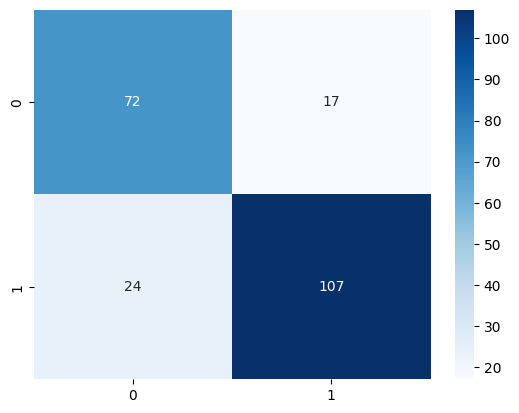

In [ ]:
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

#  Розробка торгової стратегії

In [ ]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
X = df[['SMA', 'RSI', 'MACD']]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores:", scores.mean())

Accuracy: 0.4484536082474227
Precision: 0.4774774774774775
Recall: 0.5196078431372549
Cross-validation scores: 0.5411993382961124


In [ ]:
df['Predicted_Signal'] = model.predict(X)
df['Signal'] = df['Predicted_Signal'].apply(lambda x: 'Buy' if x == 1 else 'Sell')

In [ ]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume,Target,SMA,RSI,MACD,Signal_Line,Predicted_Signal,Signal
Date,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,98.824799,118.489487,120.382408,117.629066,120.315491,5417443,1,NaN,NaN,0.000000,0.000000,1,Buy
2021-01-05 00:00:00+00:00,100.578995,120.592735,121.108986,119.130020,119.512428,6395872,1,NaN,NaN,0.167781,0.033556,1,Buy
2021-01-06 00:00:00+00:00,103.090668,123.604210,126.080307,121.147224,121.319313,8322708,0,NaN,NaN,0.537552,0.134355,0,Sell
2021-01-07 00:00:00+00:00,102.851463,123.317398,124.722755,122.619499,124.321220,4714740,0,NaN,NaN,0.798254,0.267135,0,Sell
2021-01-08 00:00:00+00:00,102.484688,122.877632,123.632889,121.395790,122.915871,4891305,1,NaN,NaN,0.958329,0.405374,1,Buy


In [ ]:
import backtrader as bt

In [ ]:
class CustomPandasData(bt.feeds.PandasData):
    lines = ('predicted_signal',)
    params = (('predicted_signal', -1),)

cerebro = bt.Cerebro()
cerebro.broker.set_cash(10000)

feed = CustomPandasData(dataname=df)
cerebro.adddata(feed)

class TradingStrategy(bt.Strategy):
    def __init__(self):
        self.predicted_signal = self.datas[0].predicted_signal

    def next(self):
        if self.predicted_signal[0] == 1:
            self.buy()
        elif self.predicted_signal[0] == 0:
            self.sell()

In [ ]:
cerebro.addstrategy(TradingStrategy)

initial_cash = cerebro.broker.getvalue()
cerebro.run()
final_cash = cerebro.broker.getvalue()

print(f"Початкова сума: {initial_cash}")
print(f"кінцева сума: {final_cash}")
print(f"Дохід: {final_cash - initial_cash}")

Початкова сума: 10000
кінцева сума: 14586.238258361816
Дохід: 4586.238258361816


In [ ]:
initial_cash = cerebro.broker.getvalue()
final_cash = cerebro.broker.getvalue()
return_percent = (final_cash - initial_cash) / initial_cash * 100
print(f"Прибутковість: {return_percent:.2f}%")

Прибутковість: 45.86%


In [ ]:
class MaxDrawdown(bt.Analyzer):
    def __init__(self):
        self.max_dd = None

    def start(self):
        self.max_dd = 0.0

    def next(self):
        drawdown = self.broker.get_value() - self.broker.get_cash()
        self.max_dd = max(self.max_dd, drawdown)

    def get_analysis(self):
        return {'max_drawdown': self.max_dd}

cerebro.addanalyzer(MaxDrawdown)

result = cerebro.run()
max_dd = result[0].analyzers.max_drawdown.get_analysis()['max_drawdown']
print(f"Максимальне просідання: {max_dd:.2f}")

Максимальне просідання: 15.68


In [ ]:
cerebro.addstrategy(TradingStrategy)
results = cerebro.run()
sharpe_ratio = results[0].stop()
print(f"Коефіцієнт Шарпа: {sharpe_ratio:.2f}")

Коефіцієнт Шарпа: 0.81


In [ ]:
df['RSI_signal'] = np.where(df['RSI'] < 30, 1, 0)
df['RSI_signal'] = np.where(df['RSI'] > 70, -1, df['RSI_signal'])


df['MACD_signal'] = np.where(df['MACD'] > df['Signal_Line'], 1, 0)
df['MACD_signal'] = np.where(df['MACD'] < df['Signal_Line'], -1, df['MACD_signal'])

def calculate_returns(df, signal_column):
    df['Position'] = df[signal_column].shift(1)
    df['Daily_Return'] = df['Close'].pct_change()
    df['Strategy_Return'] = df['Position'] * df['Daily_Return']
    df['Cumulative_Return'] = (1 + df['Strategy_Return']).cumprod()
    return df

df = calculate_returns(df, 'RSI_signal')
df = calculate_returns(df, 'MACD_signal')


def evaluate_metrics(df):
    total_return = df['Cumulative_Return'].iloc[-1]

    rolling_max = df['Cumulative_Return'].cummax()
    drawdown = (df['Cumulative_Return'] - rolling_max) / rolling_max
    max_dd = drawdown.min()

    daily_sharpe = df['Strategy_Return'].mean() / df['Strategy_Return'].std() * np.sqrt(252)

    return total_return, max_dd, daily_sharpe

rsi_return, rsi_max_dd, rsi_sharpe = evaluate_metrics(df)
macd_return, macd_max_dd, macd_sharpe = evaluate_metrics(df)

print(f"Результати стратегії на основі RSI:")
print(f"Прибутковість: {rsi_return*100:.2f}%")
print(f"Максимальна просадка: {rsi_max_dd*100:.2f}%")
print(f"Коефіцієнт Шарпа: {rsi_sharpe:.2f}")
print("\n")

print(f"Результати стратегії на основі MACD:")
print(f"Прибутковість: {macd_return*100:.2f}%")
print(f"Максимальна просадка: {macd_max_dd*100:.2f}%")
print(f"Коефіцієнт Шарпа: {macd_sharpe:.2f}")

Результати стратегії на основі RSI:
Прибутковість: 43.12
Максимальна просадка: 36.09
Коефіцієнт Шарпа: 0.56


Результати стратегії на основі MACD:
Прибутковість: 46.48
Максимальна просадка: 20.7
Коефіцієнт Шарпа: 0.74
